In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [2]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    if rescale:
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    return img
    

def get_pixels_hu(image_path, rescale=True): ## Just using hu values
        dicom = pydicom.read_file(image_path)
        image = dicom.pixel_array.astype(np.int16)

    # The intercept is usually -1024, so air is approximately 0
         
    # Convert to Hounsfield units (HU)
        intercept = dicom.RescaleIntercept
        slope = dicom.RescaleSlope
    
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        
        image += np.int16(intercept)
    
        image[image < -1024] = -1024 # Setting values smaller than air, to air .
        if rescale:
        # Extra rescaling to 0-1
            image = (image - 0) / (max(max(image))- 0)
        return np.array(image, dtype=np.int16)
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)      
    
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def img_crop(img):
    thresholded = cv2.threshold(img.astype('uint8'),0,255,cv2.THRESH_OTSU)
    bbox = cv2.boundingRect(thresholded[1])
    x, y, w, h = bbox
    foreground = img[y:y+h, x:x+w]
    return foreground


def preprocess(dcm):    
    window_center , window_width, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array
    img = window_image(img, window_center, window_width, intercept, slope)
    img = img_crop(img)
    resized = cv2.resize(img, (224, 224))
    return resized

In [3]:
dcm = pydicom.dcmread('./ID_0002a616e.dcm')

In [4]:
image = preprocess(dcm) #we read the image and store it into variables
imagekern = preprocess(dcm)
imagefinal = preprocess(dcm)

In [5]:
kernel1 = np.array([[0,-1/4,0],[-1/4,1,-1/4],[0,-1/4,0]]) #this is our desired filter

In [6]:
a = np.zeros((image.shape[0],image.shape[1])) #zeros array to store values 
b = np.zeros((image.shape[0],image.shape[1]))

In [7]:
for i in range(1,image.shape[0] - 1): #we apply linear filtering of the kernel across the image, ignoring edges
    for j in range(1,image.shape[1]-1):
        a[i][j] = kernel1[0][1]*image[i-1][j]+ kernel1[1][0]*image[i][j-1] + kernel1[1][2]*image[i][j+1] + kernel1[2][1]*image[i+1][j] + image[i][j]*kernel1[1][1]

In [8]:
for i in range(1,imagekern.shape[0]-1): #we update values on image format
    for j in range(1,imagekern.shape[1]-1):
        imagekern[i][j] = a[i][j]

In [9]:
for i in range(1,image.shape[0] - 1): #we store values on array from original image
    for j in range(1,image.shape[1]-1):
        b[i][j] = image[i][j]

In [10]:
for i in range(1,imagefinal.shape[0] - 1): #to update values of pass filter and original image
    for j in range(1,imagefinal.shape[1]-1):
        imagefinal[i][j] = 0.5*a[i][j] + b[i][j]

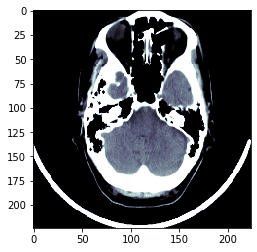

In [11]:
plt.imshow(image, cmap=plt.cm.bone) #original image

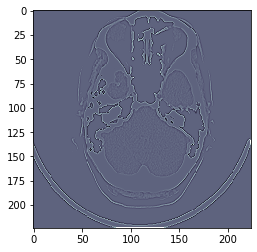

In [12]:
plt.imshow(imagekern, cmap=plt.cm.bone) #filter

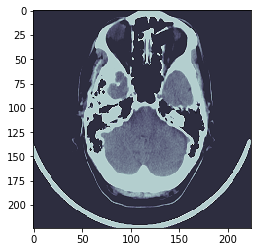

In [13]:
plt.imshow(imagefinal, cmap=plt.cm.bone) #original plus filter

## Problem 2

In [14]:
image2 = preprocess(dcm) #we read the image and store it into variables
imagekern2 = preprocess(dcm)
imagefinal2 = preprocess(dcm)

In [15]:
kernel2 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) #this is our gradient x filter

In [16]:
a2 = np.zeros((image2.shape[0],image2.shape[1])) #zeros array to store values 
b2 = np.zeros((image2.shape[0],image2.shape[1]))

In [17]:
for i in range(1,image2.shape[0] - 1): #we apply convolution of the kernel across the image, ignoring edges
    for j in range(1,image2.shape[1]-1):
        a2[i][j] = kernel2[2][2]*image2[i-1][j-1]+ kernel2[2][1]*image2[i-1][j] + kernel2[2][0]*image2[i-1][j+1] + kernel2[1][0]*image2[i][j-1] + kernel2[1][1]*image2[i][j]+kernel2[1][2]*image2[i][j-1]+kernel2[0][2]*image2[i+1][j-1]+kernel2[0][1]*image2[i+1][j]+ kernel2[0][0]*image2[i+1][j+1]

In [18]:
for i in range(1,imagekern2.shape[0]-1): #we update values on image format
    for j in range(1,imagekern2.shape[1]-1):
        imagekern2[i][j] = a2[i][j]

In [19]:
for i in range(1,image2.shape[0] - 1): #we store values on array from original image
    for j in range(1,image2.shape[1]-1):
        b2[i][j] = image2[i][j]

In [20]:
for i in range(1,imagefinal2.shape[0] - 1): #to update values of pass filter and original image
    for j in range(1,imagefinal2.shape[1]-1):
        imagefinal2[i][j] = 0.5*a2[i][j] + b2[i][j]

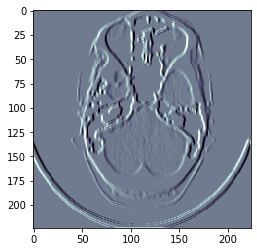

In [21]:
plt.imshow(imagekern2, cmap=plt.cm.bone) #filter

## Problem 3

In [22]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

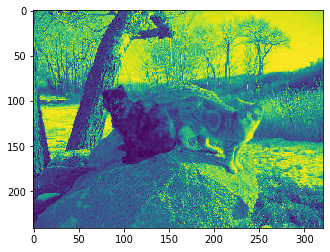

In [96]:
catpic = mpimg.imread('sample1.jpg') #we read original image
plt.imshow(catpic) 

In [146]:
catpicx = catpic.copy()
catpicy = catpic.copy()

### Part I

In [ ]:
kernelx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) #this is our gradient x filter

### Part II

In [98]:
kernely = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) #this is our gradient y filter

### Part III

In [33]:
from scipy.fftpack import fft, fftfreq

In [117]:
kernelfx = np.fft.fft2(kernelx) #kernels transformed to frequency domain
kernelfy = np.fft.fft2(kernely)

### Part IV

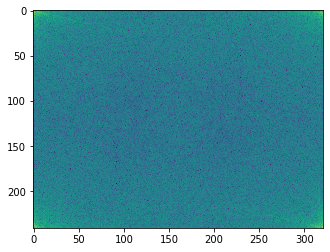

In [147]:
catpicf = np.fft.fft2(catpic) #original image transformed to frequency domain
plt.imshow(np.log(1+np.abs(catpicf))) 

### Part V

In [148]:
catpicfx = catpicf.copy()
catpicfy = catpicf.copy()

In [149]:
for i in range(1,catpicf.shape[0] - 1): #we apply convolution of the kernel across the image in frequency domain, ignoring edges
    for j in range(1,catpicf.shape[1]-1):
        catpicfx[i][j] = kernelfx[2][2]*catpicf[i-1][j-1]+ kernelfx[2][1]*catpicf[i-1][j] + kernelfx[2][0]*catpicf[i-1][j+1] + kernelfx[1][0]*catpicf[i][j-1] + kernelfx[1][1]*catpicf[i][j]+kernelfx[1][2]*catpicf[i][j-1]+kernelfx[0][2]*catpicf[i+1][j-1]+kernelfx[0][1]*catpicf[i+1][j]+ kernelfx[0][0]*catpicf[i+1][j+1]

In [150]:
for i in range(1,catpicf.shape[0] - 1): #we apply convolution of the kernel across the image in frequency domain, ignoring edges
    for j in range(1,catpicf.shape[1]-1):
        catpicfy[i][j] = kernelfy[2][2]*catpicf[i-1][j-1]+ kernelfy[2][1]*catpicf[i-1][j] + kernelfy[2][0]*catpicf[i-1][j+1] + kernelfy[1][0]*catpicf[i][j-1] + kernelfy[1][1]*catpicf[i][j]+kernelfy[1][2]*catpicf[i][j-1]+kernelfy[0][2]*catpicf[i+1][j-1]+kernelfy[0][1]*catpicf[i+1][j]+ kernelfy[0][0]*catpicf[i+1][j+1]

### Part VI

In [152]:
newcatpicx = np.fft.ifft2(catpicfx)
newcatpicy = np.fft.ifft2(catpicfy)

### Part VII

In [155]:
newcatpicxy = newcatpicx 
for i in range(1,newcatpicxy.shape[0] - 1): #we add horizontal and vertical edges
    for j in range(1,newcatpicxy.shape[1]-1):
        newcatpicxy[i][j] = newcatpicx[i][j] + newcatpicy[i][j]

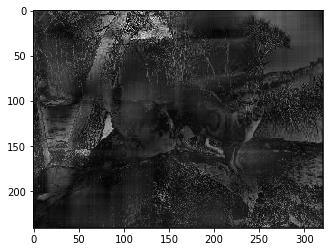

In [156]:
plt.imshow(abs(newcatpicxy),"gray")